Source of duck file: https://www.bitmanagement.de/developer/contact/nurbs/examples.htm.

In [1]:
import torch
import NURBS_PyTorch_2 as NP2
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
with open('nrbduck_0.wrl', 'r') as f:
    text = f.readlines()

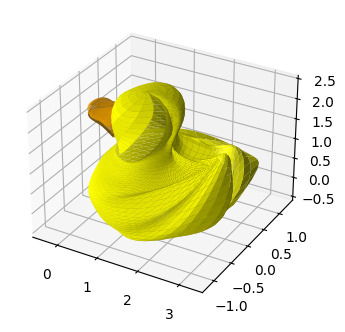

In [6]:
reading_object   = False
reading_cpts     = False
reading_knots_u  = False
reading_knots_v  = False
reading_weights  = False

fig = plt.figure(dpi = 100)
ax  = fig.add_subplot(projection = '3d')

i = 0
c = [(1,1,0),(1,2/3,0),(1,2/3,0)]

for line in text:
    
    if reading_cpts:
        
        points_string = line[:-2].split(',')
        
        for point_string in points_string:
            point = torch.tensor(list(map(float,point_string.split(' '))))
            
            control_points.append(point)
        
        if line.endswith(']\n'):
            reading_cpts = False
            
    
    elif reading_knots_u:
        knots_string = line[:-2].split(',')
        for knot_string in knots_string:
            knots_u.append(float(knot_string))
        
        if line.endswith(']\n'):
            reading_knots_u = False
            
            
    elif reading_knots_v:
        knots_string = line[:-2].split(',')
        for knot_string in knots_string:
            knots_v.append(float(knot_string))
            
        if line.endswith(']\n'):
            reading_knots_v = False
            
    elif reading_weights:
        weights_string = line[:-2].split(',')
        for weight_string in weights_string:
            weights.append(float(weight_string))
            
        if line.endswith(']\n'):
            reading_weights = False

    
    elif reading_object:
        
        if line.startswith('uDimension'):
            n_control_points_u = int(line.split(' ')[1])
            
        elif line.startswith('vDimension'):
            n_control_points_v = int(line.split(' ')[1])
            
        elif line.startswith('uTessellation'):
            n_points_u = max(int(line.split(' ')[1]),n_points_u)
            
        elif line.startswith('vTessellation'):
            n_points_v = max(int(line.split(' ')[1]),n_points_v)

        elif line.startswith('controlPoint'):
            reading_cpts   = True
            control_points = []
            
        elif line.startswith('uKnot'):
            reading_knots_u = True
            knots_u         = []
            
        elif line.startswith('vKnot'):
            reading_knots_v = True
            knots_v         = []
            
        elif line.startswith('weight'):
            reading_weights = True
            weights         = []
            
        elif line.startswith('uOrder'):
            degree_u = int(line.split(' ')[1])-1
            
        elif line.startswith('vOrder'):
            degree_v = int(line.split(' ')[1])-1
            
        elif line.endswith('}\n'):
            reading_object = False
            
            S = NP2.Surface_3D(control_net_shape = (n_control_points_u,
                                                    n_control_points_v))
            
            control_points   = torch.stack(control_points).reshape(*S.control_net_shape,3).to(S.device)
            knots_u          = torch.tensor(knots_u, device = S.device)
            
            knots_u, mults_u = torch.unique(knots_u, return_counts = True)
            knots_v          = torch.tensor(knots_v, device = S.device)
            knots_v, mults_v = torch.unique(knots_v, return_counts = True)
            
            kv_u = NP2.Knot_vector(knots_u, multiplicities = mults_u, degree = degree_u)
            kv_v = NP2.Knot_vector(knots_v, multiplicities = mults_v, degree = degree_v)
            
            S.set_parameters(basis_function_sets = [NP2.Basis_functions(kv_u),
                                                    NP2.Basis_functions(kv_v)],
                             control_point_coord_sets = [control_points[:,:,0],
                                                         control_points[:,:,1],
                                                         control_points[:,:,2]])
            
            if len(weights) > 0:
                S.include_weights = True
                S.set_parameters(weights = torch.tensor(weights).reshape(*S.control_net_shape))
            
            surface = S.eval_grid((n_points_u,n_points_v)).squeeze().cpu()
            
            ax.plot_surface(surface[:,:,0],
                            surface[:,:,1],
                            surface[:,:,2],
                            color = c[i])
            
            i += 1

        
    else:
        if line.startswith("geometry NurbsSurface"):
            reading_object = True
            
            n_points_u = 50
            n_points_v = 50
            weights    = []